<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/01_prediccion_usando_solo_endo%CC%81gena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Conv 1D**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de series temporales**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

**Notebook: Manuel Sánchez-Montañés**

**Datos: Carlos Rosado**

Librería data augmentation en series temporales:

https://github.com/uchidalab/time_series_augmentation

https://github.com/uchidalab/time_series_augmentation/blob/master/docs/AugmentationMethods.md

Notebook con ejemplos:
https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='135Md8L6aQhteU6y96uct86spAT89HqNJ',
                                        dest_path='./datos_pasajeros.csv')
    gdd.download_file_from_google_drive(file_id='12-N_wA3ZU5T3U64XnY0EIImxE3FkTgv6',
                                        dest_path='./my_utils_series_temporales.py')
    !pip install h5py==2.10.0
    # https://github.com/uchidalab/time_series_augmentation
    # https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

    !pip install gitdir
    !gitdir https://github.com/uchidalab/time_series_augmentation/tree/master/utils

     |████████████████████████████████| 2.9 MB 12.7 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Created wheel for gitdir: filename=gitdir-1.2.5-py3-none-any.whl size=5653 sha256=77de18cf656c126a30c26af2a28e2ee83b1864550b5b6ca7e2e3e99d669e72f4
  Stored in directory: /root/.cache/pip/wheels/76/e5/f1/8738f8701ec0cc0b08553b29e63a99a9687f4339e9de5d5c57
Successfully built gitdir
Downloaded: augmentation.py
Downloaded: datasets.py
Downloaded: dtw.py
Downloaded: helper.py
Downloaded: input_data.py
Downloaded: models.py
Downloaded: nemenyi.py
Downloaded: prototype_selection.py
✔ Download complete


In [ ]:
!ls

datos_pasajeros.csv  my_utils_series_temporales.py  sample_data  utils


In [ ]:
import utils.augmentation as aug

## <font color="#CA3532"> **1. Importar librerías**

In [ ]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import os

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [ ]:
!ls

datos_pasajeros.csv  my_utils_series_temporales.py  sample_data  utils


In [ ]:
data = pd.read_csv('datos_pasajeros.csv') #problema de clasificación de empresas
data.head(10)

,fecha,mes,festivo,npasajeros,semana_mes,day_of_week
0,2015-01-01,1,1,1125,0,3
1,2015-01-02,1,0,3592,0,4
2,2015-01-03,1,0,3001,0,5
3,2015-01-04,1,0,2260,0,6
4,2015-01-05,1,0,2767,0,0
5,2015-01-06,1,1,1342,0,1
6,2015-01-07,1,0,3867,0,2
7,2015-01-08,1,0,3904,1,3
8,2015-01-09,1,0,3678,1,4
9,2015-01-10,1,0,2631,1,5


In [ ]:
data.tail(10)

,fecha,mes,festivo,npasajeros,semana_mes,day_of_week
780,2017-02-19,2,0,2028,1,6
781,2017-02-20,2,0,3578,1,0
782,2017-02-21,2,0,3824,1,1
783,2017-02-22,2,0,3752,2,2
784,2017-02-23,2,0,3913,2,3
785,2017-02-24,2,0,4199,2,4
786,2017-02-25,2,0,2534,2,5
787,2017-02-26,2,0,1816,2,6
788,2017-02-27,2,0,3990,2,0
789,2017-02-28,2,0,3876,2,1


In [ ]:
!ls -la

total 48
drwxr-xr-x 1 root root  4096 Dec 18 08:13 .
drwxr-xr-x 1 root root  4096 Dec 18 08:12 ..
drwxr-xr-x 4 root root  4096 Dec  3 14:33 .config
-rw-r--r-- 1 root root 19189 Dec 18 08:13 datos_pasajeros.csv
-rw-r--r-- 1 root root  4167 Dec 18 08:13 my_utils_series_temporales.py
drwxr-xr-x 1 root root  4096 Dec  3 14:33 sample_data
drwxr-xr-x 3 root root  4096 Dec 18 08:15 utils


In [ ]:
data.shape

(790, 6)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [ ]:
type(data['fecha'][0])

str

In [ ]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['fecha'] = pd.to_datetime(data['fecha'])
type(data['fecha'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
data['fecha']

0     2015-01-01
1     2015-01-02
2     2015-01-03
3     2015-01-04
4     2015-01-05
         ...    
785   2017-02-24
786   2017-02-25
787   2017-02-26
788   2017-02-27
789   2017-02-28
Name: fecha, Length: 790, dtype: datetime64[ns]

In [ ]:
fechas      = data['fecha'].values
target      = data['npasajeros'].values # variable endógena

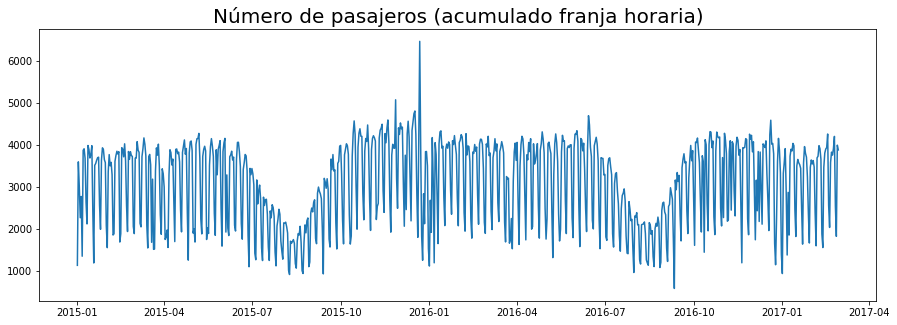

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Número de pasajeros (acumulado franja horaria)',
          fontsize=20);

Los bajones son verano. Hay una parte que es periódica pero otra no.

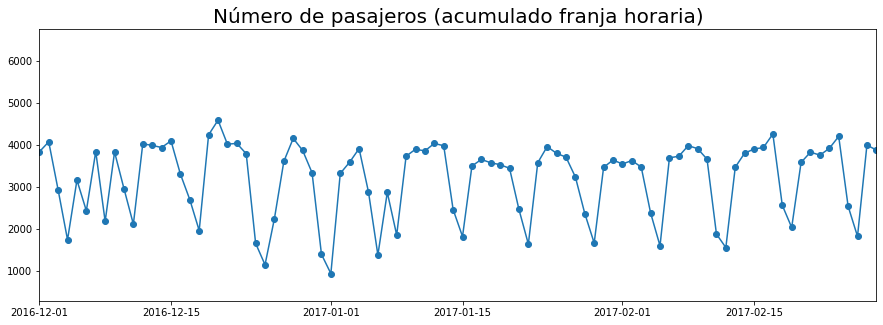

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Número de pasajeros (acumulado franja horaria)', fontsize=20)
plt.xlim([fechas[-90],fechas[-1]]);

In [ ]:
if COLAB:
    !cal 1 2017

    January 2017      
Su Mo Tu We Th Fr Sa  
 1  2  3  4  5  6  7  
 8  9 10 11 12 13 14  
15 16 17 18 19 20 21  
22 23 24 25 26 27 28  
29 30 31              
                      


Media número de viajeros    : 3065.5784810126584


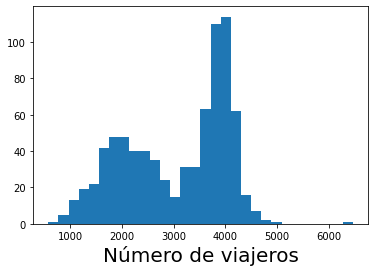

In [ ]:
plt.hist(target, bins=30)
plt.xlabel('Número de viajeros', fontsize=20)
print("Media número de viajeros    :", target.mean())

Es una distribución bimodal.

## <font color="#CA3532"> **4. Transformación de la variable a predecir**

In [ ]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/5000
def inverse_transform(x_escalado):
    return x_escalado*5000

In [ ]:
transform(np.array([1,2,3]))

array([0.0002, 0.0004, 0.0006])

## <font color="#CA3532"> **5. Enventanado de datos**

In [ ]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [ ]:
target_transf = transform(target)
target_transf[:5]

array([0.225 , 0.7184, 0.6002, 0.452 , 0.5534])

In [ ]:
series = [target_transf]
se_saben_antes = [False]
nombres_series = ["target_transf"]

In [ ]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(1, 790)
(1,)


In [ ]:
lookback = 30 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))

(790, 30, 1) (790,)


In [ ]:
series[0][:10]

array([0.225 , 0.7184, 0.6002, 0.452 , 0.5534, 0.2684, 0.7734, 0.7808,
       0.7356, 0.5262])

In [ ]:
X[5]

array([[   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [0.225 ],
       [0.7184],
       [0.6002],
       [0.452 ],
       [0.5534]])

In [ ]:
y[5]

0.2684

In [ ]:
fechas_aux = [str(x).split("T")[0] for x in fechas]

In [ ]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=fechas_aux)

10 ventanas creadas

X.shape=(10, 30, 1)  Y.shape=(10,) 

 Ventana 0: 


X[0].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 ?24 ?25 ?26 ?27 ?28 ?29 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 __ Y[0]=0.225 2015-01-01 
 
 target 
 0.225000

 Ventana 1: 


X[1].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 ?24 ?25 ?26 ?27 ?28 2015-01-01 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 
 __ Y[1]=0.7184 2015-01-02 
 
 target 
 0.718400

 Ventana 2: 


X[2].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 ?24 ?25 ?26 ?27 2015-01-01 2015-01-02 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 
 __ Y[2]=0.6002 2015-01-03 
 
 target 
 0.600200

 Ventana 3: 


X[3].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 ?24 ?25 ?26 2015-01-01 2015-01-02 2015-01-03 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 
 __ Y[3]=0.452 2015-01-04 
 
 target 
 0.452000

 Ventana 4: 


X[4].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 ?24 ?25 2015-01-01 2015-01-02 2015-01-03 2015-01-04 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 
 __ Y[4]=0.5534 2015-01-05 
 
 target 
 0.553400

 Ventana 5: 


X[5].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 ?24 2015-01-01 2015-01-02 2015-01-03 2015-01-04 2015-01-05 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 
 __ Y[5]=0.2684 2015-01-06 
 
 target 
 0.268400

 Ventana 6: 


X[6].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 2015-01-01 2015-01-02 2015-01-03 2015-01-04 2015-01-05 2015-01-06 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 
 __ Y[6]=0.7734 2015-01-07 
 
 target 
 0.773400

 Ventana 7: 


X[7].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 2015-01-01 2015-01-02 2015-01-03 2015-01-04 2015-01-05 2015-01-06 2015-01-07 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 
 __ Y[7]=0.7808 2015-01-08 
 
 target 
 0.780800

 Ventana 8: 


X[8].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 2015-01-01 2015-01-02 2015-01-03 2015-01-04 2015-01-05 2015-01-06 2015-01-07 2015-01-08 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 
 __ Y[8]=0.7356 2015-01-09 
 
 target 
 0.735600

 Ventana 9: 


X[9].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 2015-01-01 2015-01-02 2015-01-03 2015-01-04 2015-01-05 2015-01-06 2015-01-07 2015-01-08 2015-01-09 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 0.735600 
 
 __ Y[9]=0.5262 2015-01-10 
 
 target 
 0.526200

In [ ]:
print(X.shape)
print(np.shape(target))

(790, 30, 1)
(790,)


## <font color="#CA3532"> **6. Separación training-test**

In [ ]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)
punto_corte

632

In [ ]:
X_train      = X[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(602,)
(158,)


In [ ]:
print(X_train.shape, y_train.shape)

(602, 30, 1) (602,)


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [ ]:
loss = 'mean_squared_error'
#loss = "mean_absolute_percentage_error"

#optimizer = "adam"
optimizer="rmsprop"
#optimizer=optimizers.Adam(learning_rate=0.01), # más rápido

model = Sequential()
model.add(Conv1D(4, kernel_size=5, input_shape=(lookback, X_train.shape[-1])))
model.add(MaxPooling1D(2))
model.add(Conv1D(8, kernel_size=5))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1, # kernel_regularizer='l1'
               )
         )
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


In [ ]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 26, 4)             24        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 13, 4)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 9, 8)              168       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 4, 8)             0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

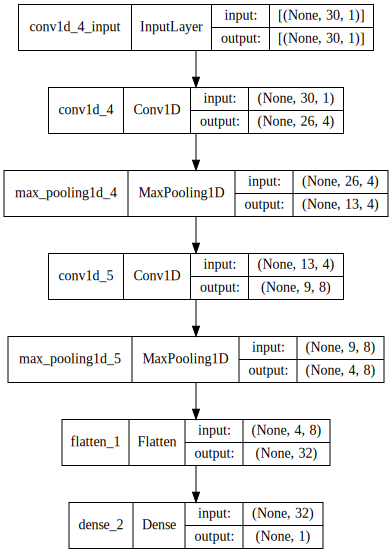

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
OS_WINDOWS = False

# Creación del directorio log en el que se va a grabar
# el grafo del modelo y resultados intermedios del proceso
# de training para visualizarlo luego en Tensorboard

log_path = 'log/'

tb_callback = TensorBoard(
    log_dir=log_path,
    histogram_freq=2,
    write_graph=True
)
tb_callback.set_model(model)
callbacks = []
callbacks.append(tb_callback)

# A continuación se trata de crear el directorio log:
# - Si no existe se crea
# - Si ya existe se borran los datos que haya dentro de él

try:
    os.mkdir(log_path)
except:
    if OS_WINDOWS:
        !del log\*
    else:
        !rm log/*

rm: cannot remove 'log/train': Is a directory



Epoch 00001: val_mse improved from inf to 0.39988, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.39988 to 0.22841, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.22841 to 0.11752, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.11752 to 0.05657, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.05657 to 0.03736, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03736 to 0.03378, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03378 to 0.03252, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03252 to 0.03130, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03130 to 0.03074, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03074 to 0.02877, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.02877 to 0.02713, saving m

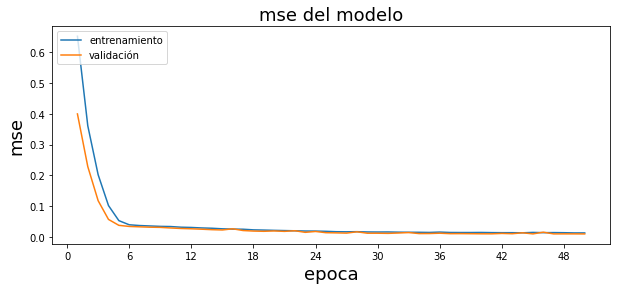


Epoch 00001: val_mse did not improve from 0.00943

Epoch 00001: val_mse did not improve from 0.00943

Epoch 00001: val_mse did not improve from 0.00943

Epoch 00001: val_mse did not improve from 0.00943

Epoch 00001: val_mse did not improve from 0.00943

Epoch 00001: val_mse improved from 0.00943 to 0.00928, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00928 to 0.00925, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse improved from 0.00925 to 0.00919, saving model to model_current_best.h5

Epo

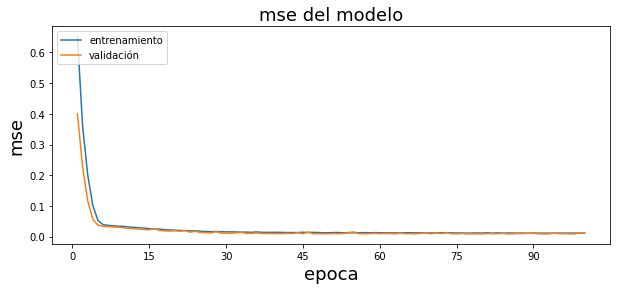


Epoch 00001: val_mse did not improve from 0.00891

Epoch 00001: val_mse did not improve from 0.00891

Epoch 00001: val_mse improved from 0.00891 to 0.00889, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve from 0.00889

Epoch 00001: val_mse did not improve f

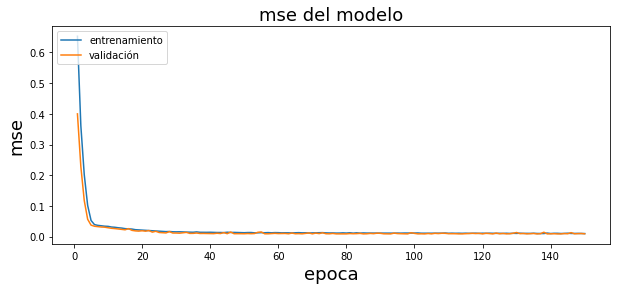


Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not improve from 0.00882

Epoch 00001: val_mse did not i

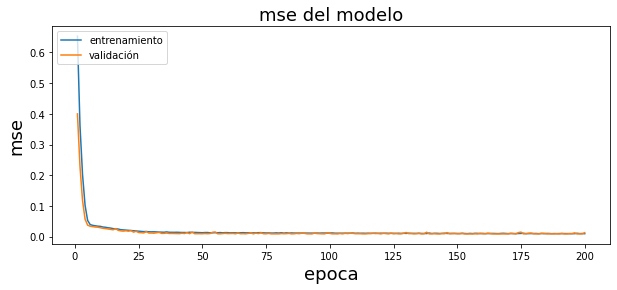

In [ ]:
epochs = 200
batch_size = 64
Nval = 200
control_sobreajuste_val = True
grabar_detalles_training_para_tensorboard = False
# si no se van a analizar estos detalles en tensorboard mejor
# poner este flag a False ya que el grabarlos enlentence
# bastante el training

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    if grabar_detalles_training_para_tensorboard:
        callbacks_list = callbacks + [checkpoint]
    else:
        callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [ ]:
model = load_model(modelpath) # recupero el mejor modelo en validación

## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [ ]:
y_train_prediction = model.predict(X_train).flatten()
y_test_prediction = model.predict(X_test).flatten()
y_train_prediction[:5]

array([0.48473415, 0.435576  , 0.63544613, 0.721855  , 0.70190257],
      dtype=float32)

In [ ]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

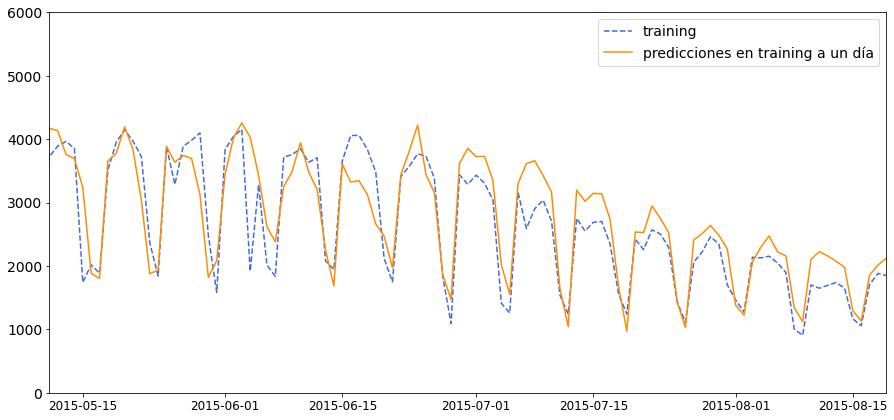

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[100],fechas_train[200],0,6000])
plt.legend(fontsize=14);

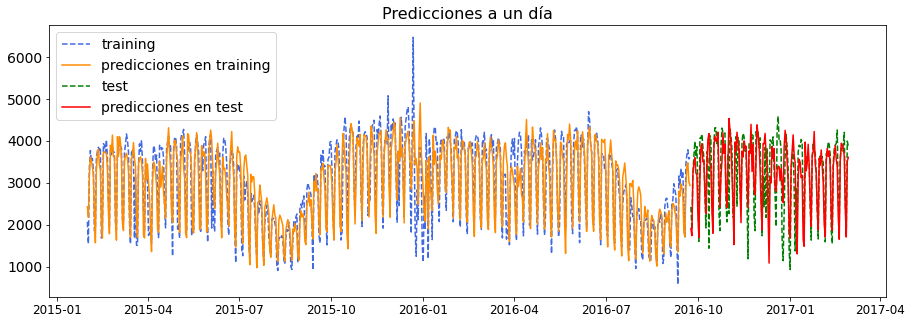

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Predicciones a un día', fontsize=16)
plt.legend(fontsize=14);

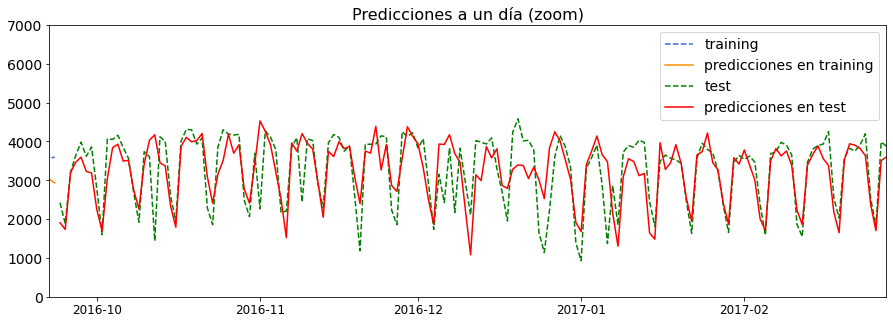

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[600],fechas_test[-1],0,7000]);

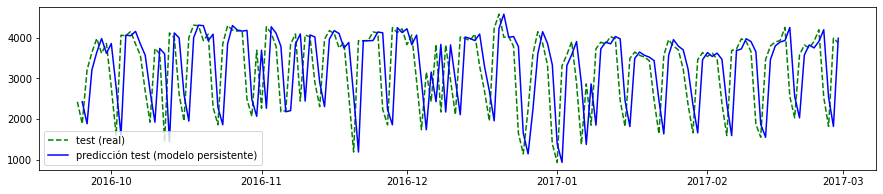

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test (real)')
plt.plot(fechas_test[1:], target_test[:-1], '-',   c='blue',
         label='predicción test (modelo persistente)')
plt.legend();

Coeficiente de determinación R2 (no r2 de Pearson)#

1 - ecm / var(y real)

In [ ]:
# Modelos de referencia (en orden de complejidad):
# 1- Predecir siempre media (mediana) en training
# 2- Modelo persistente (a 1 día, 7 días etc.)
# 3- SARIMAX


# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.7679236923461572
R2 del modelo en test          :  0.5106044234525811
R2 modelo persistente 1 día    :  -0.44768351889101354
R2 modelo persistente 1 semana :  0.3743300534633949
R2 modelo persistente 4 semanas:  0.48525679455105053
R2 modelo persistente 1 año:  0.7023710033430108


In [ ]:
# RMSEs
sqrt = np.sqrt
print("RMSE del modelo en training      : ",
      sqrt(mean_squared_error(target_train[1:],
                              target_train_pred[1:])))
print("RMSE del modelo en test          : ",
      sqrt(mean_squared_error(target_test,
                              target_test_pred)))
print("RMSE modelo persistente 1 día    : ",
      sqrt(mean_squared_error(target_test[1:],
                              target_test[:-1])))
print("RMSE modelo persistente 1 semana : ",
      sqrt(mean_squared_error(target_test[7:],
                              target_test[:-7])))
print("RMSE modelo persistente 4 semanas: ",
      sqrt(mean_squared_error(target_test[28:],
                              target_test[:-28])))

RMSE del modelo en training      :  489.7872104084695
RMSE del modelo en test          :  635.6981570955178
RMSE modelo persistente 1 día    :  1093.8023843688381
RMSE modelo persistente 1 semana :  724.5713553588926
RMSE modelo persistente 4 semanas:  654.1568971996292


## <font color="#CA3532"> **9. Predicciones a varios días en test mediante un modelo generativo**

¿Cómo hago para predecir, si hoy es sábado, el número de pasajeros el lunes?

El número de pasajeros los 4 últimos días, y los de hoy son:

[100, 300, 200, 500, 700]

- Primero: predices pasajeros mañana domingo. Por ejemplo, la red dice que son 1000

- Segundo: asumes que la predicción es completamente correcta, y construyes la ventana para mañana:

[300, 200, 500, 700, **1000**]

- Tercero: predices con esa ventana el número de pasajeros el lunes.

In [ ]:
def step_generativo(model, ventana, X, i):
    # ventana: va a tener dimensiones (1, lookback, n_variables)
    # El target está en (0,:,0)
    # La posición (0,0,0) es el target en el día más antiguo de la ventana
    # La posición (0,0,-1) es el target en el día más reciente de la ventana
    # Las variables calendario están en (0,:,1:)
    # Las variables calendario para el último día de la ventana están en (0,-1,1:)

    z = model.predict(ventana)[0,0] # predicción nueva
    target_pred = inverse_transform(z)
    ventana_nueva = None
    if i < (len(X)-1):
        ventana_nueva = np.zeros(ventana.shape)
        # muevo un día hacia atrás todas las variables de la ventana:
        ventana_nueva[0,:-1,:] = ventana[0,1:,:].copy()

        # introduzco las variables calendario para el último día de la ventana:
        ventana_nueva[0,-1,1:] = X[i+1,-1,1:]

        # meto la predicción como última obervación del target:
        ventana_nueva[0,-1,0] = z
        
        
    return target_pred, ventana_nueva

In [ ]:
def generativo(model, X):
    ventana = np.array([X[0]]).copy()    
    salidas = []
    for i in range(len(X)):
        target_pred, ventana_nueva = step_generativo(model, ventana, X, i)
        salidas.append(target_pred)
        ventana = ventana_nueva
    
    return salidas

In [ ]:
sal = generativo(model, X_test)

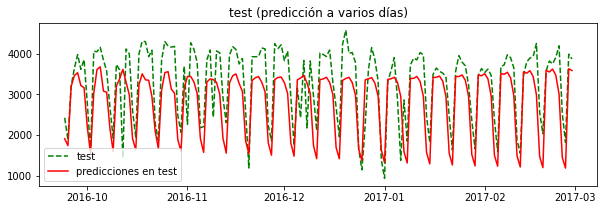

In [ ]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(fechas_test, target_test, '--g', label='test')
plt.plot(fechas_test, sal, 'r', label='predicciones en test')
plt.title('test (predicción a varios días)')
plt.legend();

In [ ]:
if grabar_detalles_training_para_tensorboard:
    import webbrowser
    if COLAB:
        %load_ext tensorboard
        %tensorboard --logdir $log_path
    else:
        webbrowser.open_new('http://localhost:6006')
        os.system('tensorboard --logdir=' + log_path)

### **"Heatmaps" de la predicción: ¿qué inputs han influido más en la predicción?**

In [ ]:
print(nombres_series)
print(len(nombres_series))
print(X_test.shape)

['target_transf']
1
(158, 30, 1)


In [ ]:
len(se_saben_antes)

1

In [ ]:
i = 0
print(fechas_test[i]) # 24/09/2016 fue sábado
sample = X_test[i:(i+1)].copy()
sample.shape

2016-09-24T00:00:00.000000000


(1, 30, 1)

In [ ]:
info_enventanado(X_test[i:(i+1)],y[i:(i+1)],
                 nombres_series=nombres_series,
                 nombre_target="target_transf",
                 tiempos=fechas_test[i:(i+1)])

1 ventanas creadas

X.shape=(1, 30, 1)  Y.shape=(1,) 

 Ventana 0: 


X[0].shape=(30, 1) ?0 ?1 ?2 ?3 ?4 ?5 ?6 ?7 ?8 ?9 ?10 ?11 ?12 ?13 ?14 ?15 ?16 ?17 ?18 ?19 ?20 ?21 ?22 ?23 ?24 ?25 ?26 ?27 ?28 ?29 
 
 target_transf 
 0.455000 
 0.423200 
 0.214600 
 0.239000 
 0.486400 
 0.522400 
 0.526200 
 0.479800 
 0.466000 
 0.306400 
 0.243600 
 0.505400 
 0.515600 
 0.595000 
 0.566800 
 0.540600 
 0.346200 
 0.114800 
 0.631800 
 0.585400 
 0.667600 
 0.624800 
 0.653800 
 0.461000 
 0.341400 
 0.690600 
 0.731000 
 0.757000 
 0.713400 
 0.719400 
 
 __ Y[0]=0.225 2016-09-24 00:00:00 
 
 target_transf 
 0.225000

In [ ]:
pred0 = model.predict(sample)[0][0]
delta = 1e-3
w_in = sample.shape[1]

print("SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:\n")
for i,x in enumerate(nombres_series):
    for j in range(w_in):
        sample_pert = sample.copy()
        sample_pert[0,j,i] += delta
        pred_pert = model.predict(sample_pert)[0][0]
        if se_saben_antes[i]:
            print("{} (t-{}) [ADELANTADA]: {:.3f}".format(x, w_in-j, (pred_pert - pred0) / delta))
        else:
            print("{} (t-{}): {:.3f}".format(x, w_in-j, (pred_pert - pred0) / delta))

SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:

target_transf (t-30): 0.000
target_transf (t-29): -0.019
target_transf (t-28): 0.055
target_transf (t-27): -0.035
target_transf (t-26): -0.072
target_transf (t-25): -0.048
target_transf (t-24): 0.071
target_transf (t-23): 0.035
target_transf (t-22): -0.112
target_transf (t-21): 0.267
target_transf (t-20): -0.001
target_transf (t-19): -0.116
target_transf (t-18): -0.044
target_transf (t-17): -0.199
target_transf (t-16): 0.023
target_transf (t-15): 0.228
target_transf (t-14): 0.062
target_transf (t-13): 0.187
target_transf (t-12): -0.104
target_transf (t-11): 0.006
target_transf (t-10): -0.198
target_transf (t-9): -0.023
target_transf (t-8): 0.236
target_transf (t-7): 0.249
target_transf (t-6): -0.037
target_transf (t-5): 0.256
target_transf (t-4): 0.112
target_transf (t-3): -0.012
target_transf (t-2): 0.000
target_transf (t-1): 0.000


### **Función que saca por pantalla todos los parámetros de todas las capas de la red**

In [ ]:
def info_red(modelo):
    for i,layer in enumerate(modelo.layers):
        print('* Capa {} [Nombre: "{}"]'.format(i,layer.name))
        print('  Tipo:', type(layer))
        print("  Propiedades:")
        aux = layer.get_config()
        for k in aux:
            print("    {}: {}".format(k, aux[k]))
        print()

In [ ]:
# información detallada de todos los parámetros de cada capa del modelo:
info_red(model)

* Capa 0 [Nombre: "conv1d_4"]
  Tipo: <class 'keras.layers.convolutional.Conv1D'>
  Propiedades:
    name: conv1d_4
    trainable: True
    batch_input_shape: (None, 30, 1)
    dtype: float32
    filters: 4
    kernel_size: (5,)
    strides: (1,)
    padding: valid
    data_format: channels_last
    dilation_rate: (1,)
    groups: 1
    activation: linear
    use_bias: True
    kernel_initializer: {'class_name': 'GlorotUniform', 'config': {'seed': None}}
    bias_initializer: {'class_name': 'Zeros', 'config': {}}
    kernel_regularizer: None
    bias_regularizer: None
    activity_regularizer: None
    kernel_constraint: None
    bias_constraint: None

* Capa 1 [Nombre: "max_pooling1d_4"]
  Tipo: <class 'keras.layers.pooling.MaxPooling1D'>
  Propiedades:
    name: max_pooling1d_4
    trainable: True
    dtype: float32
    strides: (2,)
    pool_size: (2,)
    padding: valid
    data_format: channels_last

* Capa 2 [Nombre: "conv1d_5"]
  Tipo: <class 'keras.layers.convolutional.Conv1D'>